### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

# Altair
import altair as alt
alt.renderers.enable('notebook')

### Removes warnings that occassionally show up
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [227]:
DATA_PATH = "../../data/Forest-Cover/"

train = pd.read_csv(DATA_PATH + "train.csv")
test  = pd.read_csv(DATA_PATH + "test.csv")
predictions = pd.read_csv(DATA_PATH + "predictions.csv")

cat_columns = [col for col in train.columns if train[col].dtype == object]
print("Categorical columns:")
print(" --- ".join(cat_columns))

### Numerical columns
num_columns = [col for col in train.columns if train[col].dtype != object]
print("Numerical columns:")
print(" --- ".join(num_columns))
print()
print("Shape of train:", train.shape)
print("Shape of test:",  test.shape)

Categorical columns:

Numerical columns:
Id --- Elevation --- Aspect --- Slope --- Horizontal_Distance_To_Hydrology --- Vertical_Distance_To_Hydrology --- Horizontal_Distance_To_Roadways --- Hillshade_9am --- Hillshade_Noon --- Hillshade_3pm --- Horizontal_Distance_To_Fire_Points --- Wilderness_Area1 --- Wilderness_Area2 --- Wilderness_Area3 --- Wilderness_Area4 --- Soil_Type1 --- Soil_Type2 --- Soil_Type3 --- Soil_Type4 --- Soil_Type5 --- Soil_Type6 --- Soil_Type7 --- Soil_Type8 --- Soil_Type9 --- Soil_Type10 --- Soil_Type11 --- Soil_Type12 --- Soil_Type13 --- Soil_Type14 --- Soil_Type15 --- Soil_Type16 --- Soil_Type17 --- Soil_Type18 --- Soil_Type19 --- Soil_Type20 --- Soil_Type21 --- Soil_Type22 --- Soil_Type23 --- Soil_Type24 --- Soil_Type25 --- Soil_Type26 --- Soil_Type27 --- Soil_Type28 --- Soil_Type29 --- Soil_Type30 --- Soil_Type31 --- Soil_Type32 --- Soil_Type33 --- Soil_Type34 --- Soil_Type35 --- Soil_Type36 --- Soil_Type37 --- Soil_Type38 --- Soil_Type39 --- Soil_Type40 --- 

### Split into id, target, and predictors

In [3]:
train_y = train["Cover_Type"]
train_id = train["Id"]
train_x = train.drop(["Cover_Type", "Id"], axis=1)

test_id = test["Id"]
test_x  = test.drop("Id", axis=1)

full    = pd.concat([train_x, test_x])
train_N = len(train_x)

### Train/Test size difference

In [4]:
temp = pd.DataFrame({"Dataset": ["Train", "Test"], "Number of Records": [train.shape[0], test.shape[0]]})

trace = go.Pie(labels=temp["Dataset"], values=temp["Number of Records"],
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(line=dict(color="black", width=2)))

layout = go.Layout(
    title = "Train/Test size difference",
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig);

### Target: Cover_Type

Nice, seems very boring

In [311]:
vc = train_y.value_counts()

trace = go.Bar(
    x=vc.index,
    y=vc.values,
)

layout = go.Layout(
    title   = "Cover Type shown in Train",
    xaxis   = dict(title = "Cover Type"),
    yaxis   = dict(title = "Count")
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig);

### Correlation Plot

In [6]:
ignore_feats = [col for col in full.columns if "Soil_Type" in col]
corr         = full.drop(ignore_feats, axis=1).corr().round(3)

trace = go.Heatmap(
    x = corr.columns,
    y = corr.index,
    z = corr.values,
)

buttons = []

layout = dict(title = 'Correlation plots')

fig = dict(data=[trace], layout=layout)
iplot(fig)

### Distance to Hydrology

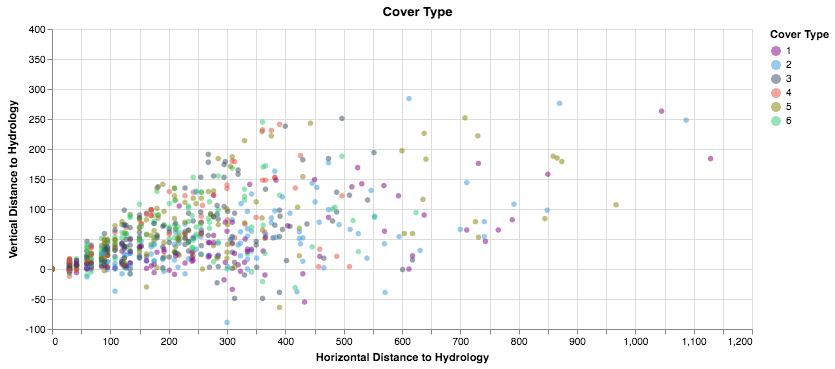

In [9]:
temp = train[["Cover_Type", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"]].sample(1000)
temp["Cover_Type"] = temp["Cover_Type"].map(str)
temp.columns = ["Cover Type", "Horizontal Distance to Hydrology", "Vertical Distance to Hydrology"]

click = alt.selection_multi(fields=['Cover Type'])
palette = alt.Scale(domain=["1", "2", "3", "4", "5", "6"],
                    range=["purple", "#3498db", "#34495e", "#e74c3c", "olive", "#2ecc71"])


(alt.Chart(temp)
 .mark_circle()
 .encode(
     x='Horizontal Distance to Hydrology',
     y='Vertical Distance to Hydrology',
     opacity=alt.value(0.5),
     tooltip=['Cover Type', "Horizontal Distance to Hydrology", "Vertical Distance to Hydrology"],
     color=alt.condition(click, 'Cover Type',
                         alt.value('lightgray'), scale=palette))
 .properties(selection=click, width=700, title="Cover Type")
 .interactive())

### Slope and Elevation

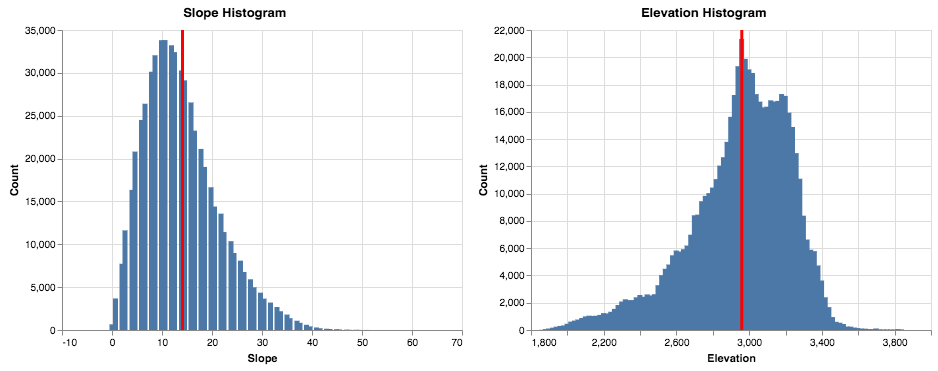

In [105]:
def alt_hist_chart(df, feat):
    temp1 = np.histogram(full[feat], bins=100)
    temp1 = pd.DataFrame({feat: temp1[1][:-1].round(1), "Count": temp1[0]})

    bar = alt.Chart(temp1).mark_bar().encode(
        alt.X(feat, axis=alt.Axis(title=feat)),
        y = 'Count:Q',

        tooltip=[feat, "Count"]
    )

    temp2 = pd.DataFrame({"Mean": [round(full[feat].mean(), 1)]})
    line = alt.Chart(temp2).mark_rule(color='red').encode(
        alt.X("Mean:Q", axis=alt.Axis(title=feat)),
        size=alt.value(3),
        tooltip=["Mean"],
    )
    return (bar + line).properties(title=f"{feat} Histogram").interactive()


slope_chart     = alt_hist_chart(full, "Slope")
elevation_chart = alt_hist_chart(full, "Elevation")

alt.hconcat(slope_chart, elevation_chart)

### Hillshade

In [313]:
plotly_data = []

cover_types = range(1, 8)
colors = ["purple", "#3498db", "#34495e", "#e74c3c", "teal", "#2ecc71", "olive"]

for cover_type, color in zip(cover_types, colors):
    temp = train[train["Cover_Type"] == cover_type]
    trace = go.Scatter3d(
        x=temp["Hillshade_9am"],
        y=temp["Hillshade_Noon"],
        z=temp["Hillshade_3pm"],
        mode='markers',
        name = f"Cover Type {cover_type}",
        marker=dict(
            size=2,
            line=dict(
                color=color,
                width=0.5
            ),
            opacity=1
        )
    )
    plotly_data.append(trace)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    title="Hillshade distribution across target",
    scene=go.Scene(
        xaxis=go.XAxis(title='x - 9am'),
        yaxis=go.YAxis(title='y - Noon'),
        zaxis=go.ZAxis(title='z - 3pm')
    ),
    legend=dict(
        x=0,
        y=0.5,
        bordercolor='#000',
        borderwidth=1
    )
)
fig = go.Figure(data=plotly_data, layout=layout)
iplot(fig)

### Wilderness Areas

In [284]:
feats = ["Wilderness_Area1", "Wilderness_Area2",  "Wilderness_Area3", "Wilderness_Area4"]

train["Wilderness_Area"] = ((1 * train["Wilderness_Area1"]) +
                            (2 * train["Wilderness_Area2"]) +
                            (3 * train["Wilderness_Area3"]) +
                            (4 * train["Wilderness_Area4"])).map(str)

vcs = pd.DataFrame()
for cover_type in range(1, 8):
    temp = train[train["Cover_Type"] == cover_type]
    vc   = temp["Wilderness_Area"].value_counts()
    size = len(temp)
    vc   = (vc / size).round(2)
    vc = pd.DataFrame(vc).T
    vc.index = [cover_type]
    vcs = pd.concat([vcs, vc])

plotly_data = []
for area in range(1, 5):
    vc = vcs[str(area)]
    trace = go.Bar(
        x=vc.index,
        y=vc.values,
        name=f"Area {area}"
    )
    plotly_data.append(trace)
    
layout = go.Layout(
    barmode = 'group',
    title   = "Wilderness Area",
    xaxis   = dict(title = "Cover Type"),
    yaxis   = dict(title = "Fraction")
)

fig = go.Figure(data=plotly_data, layout=layout)
iplot(fig);

### Soil Type

Interesting the two distributions are not similar at all!  These columns may have to be cleaned.

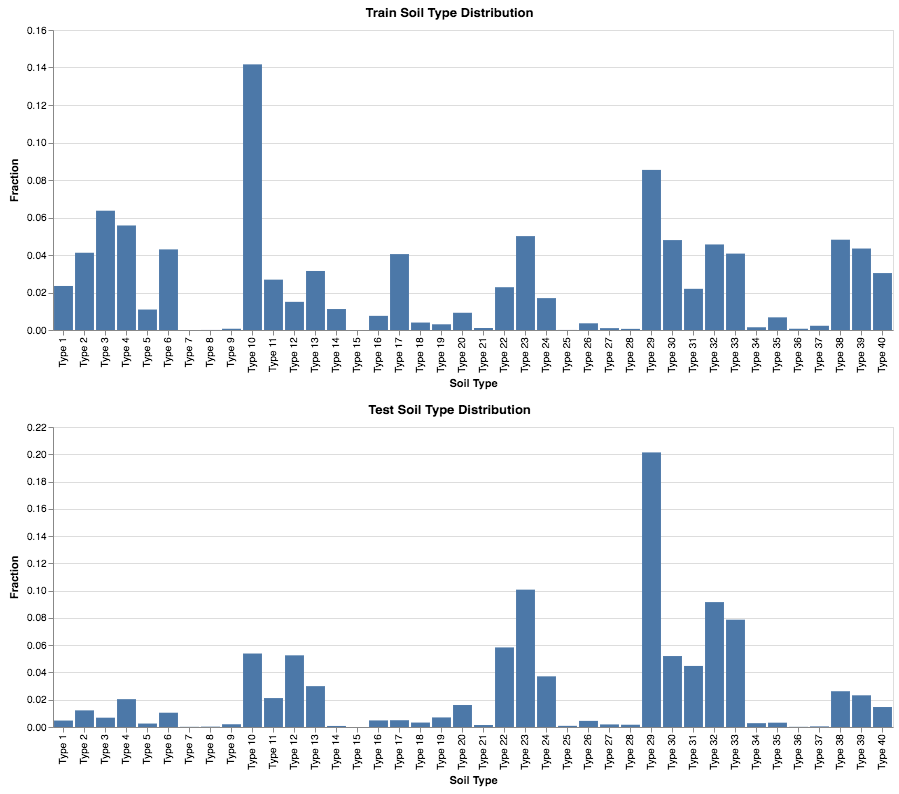

In [139]:
def alt_soil_types(df, title=None):
    soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
    
    temp = pd.DataFrame(df[soil_types].mean()).reset_index()
    temp.columns = ["Soil Type", "Fraction"]

    temp["Soil Type"] = temp["Soil Type"].map(lambda x: int(x.replace("Soil_Type", "")))
    temp = temp.sort_values("Soil Type")
    temp["Soil Type"] = temp["Soil Type"].map(lambda x: "Type " + str(x))
    temp["Fraction"]  = temp["Fraction"].round(5)

    chart = alt.Chart(temp).mark_bar().encode(
        alt.X("Soil Type:O", sort=None),
        alt.Y("Fraction:Q"),
        tooltip=["Soil Type", "Fraction"],
    ).properties(title=title)
    return chart

soil_types_train = alt_soil_types(train, title="Train Soil Type Distribution")
soil_types_test  = alt_soil_types(test, title="Test Soil Type Distribution")

alt.vconcat(soil_types_train, soil_types_test)

### Roadways and Fire Points

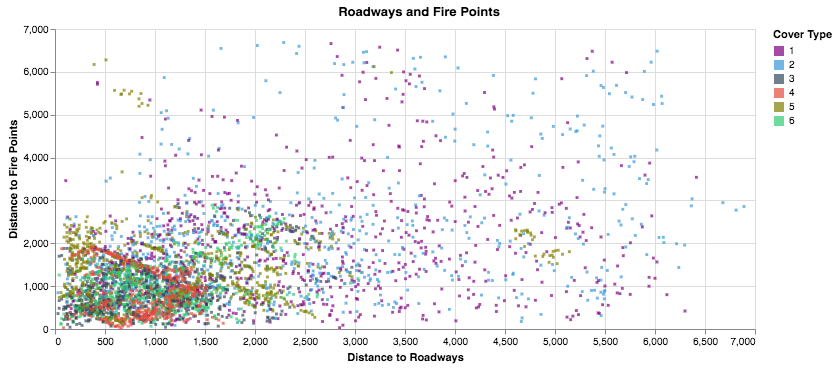

In [323]:
feats = ["Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", "Cover_Type"]
temp  = train[feats].sample(5000)

temp["Cover_Type"] = temp["Cover_Type"].map(str)
temp.columns = ["Distance to Roadways", "Distance to Fire Points", "Cover Type"]


click = alt.selection_multi(fields=['Cover Type'])
palette = alt.Scale(domain=["1", "2", "3", "4", "5", "6"],
                    range=["purple", "#3498db", "#34495e", "#e74c3c", "olive", "#2ecc71"])


(alt.Chart(temp)
 .mark_square(size=8)
 .encode(
     x='Distance to Roadways',
     y='Distance to Fire Points',
     opacity=alt.value(0.7),
     tooltip=['Cover Type', "Distance to Roadways", "Distance to Fire Points"],
     color=alt.condition(click, 'Cover Type',
                         alt.value('lightgray'), scale=palette))
 .properties(selection=click, width=700, title="Roadways and Fire Points")
 .interactive())

### Predictions

In [315]:
vc = predictions["Cover_Type"].value_counts()

trace = go.Bar(
    x=vc.index,
    y=vc.values,
)

layout = go.Layout(
    title   = "Cover Type shown in Predictions (Score: 81% accurate)",
    xaxis   = dict(title = "Cover Type"),
    yaxis   = dict(title = "Count")
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig);